In [2]:
# here we load a pretrained MobilenetV2 model and get the feature map
# https://github.com/d-li14/mobilenetv2.pytorch
from torchvision import models
import torch
model = models.mobilenet_v2(pretrained=True)
# save the pretrained weight
torch.save(model.state_dict(), './Weights/pretrained_mobilenetv2_imagenet.pth')
# dataloader imagenet
from Dataloaders.dataloader_imagenet import Dataset_imagenet, Dataloader_imagenet
imagenet = Dataset_imagenet('home')
_, test, _ = imagenet.return_sampler()
_, test_set, _ = imagenet.return_dict()


test_loader = Dataloader_imagenet(test, test_set, transform = True)
test_loader = torch.utils.data.DataLoader(test_loader, batch_size=100, shuffle=True)

model = model.cuda()
model.eval()
# get the first image
labels = torch.tensor([])
outputs = torch.tensor([])
for ind, (image, label) in enumerate(test_loader):
    labels = torch.cat((labels, label))
    image = image.cuda()
    output = model(image)
    outputs = torch.cat((outputs, output.cpu().detach()), dim=0)
    if ind == 10:
        break
# forward pass
output = model(image)
# get the max
max_output = torch.argmax(output, dim=1).cpu().detach()
print(max_output==label)

/home/tonypeng/anaconda3/envs/iot/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tonypeng/anaconda3/envs/iot/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([False,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True, False,  True,  True,
         True, False,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True, False,  True,  True, False,  True,  True,  True,  True, False,
         True, False,  True,  True,  True,  True,  True,  True, False,  True])


In [3]:
from Models.mobilenetv2_original import stupid_model_splitter
import numpy as np
client, server = stupid_model_splitter(weight_path='./Weights/pretrained_mobilenetv2_imagenet.pth')
# forward pass
client_output = client(image)
# count zeros
result = np.sum(np.where(client_output==0, 1, 0))
print(result)
print(client_output.shape)
print(result/np.prod(client_output.shape))

# check is a channel is all zeros
zero_channels = 0
for i in range (client_output.shape[0]):
    for j in range (client_output.shape[1]):
        if torch.sum(client_output[i,j,:,:])==0:
            zero_channels+=1
print(zero_channels)

14245148
torch.Size([100, 32, 112, 112])
0.3548795240752551
416


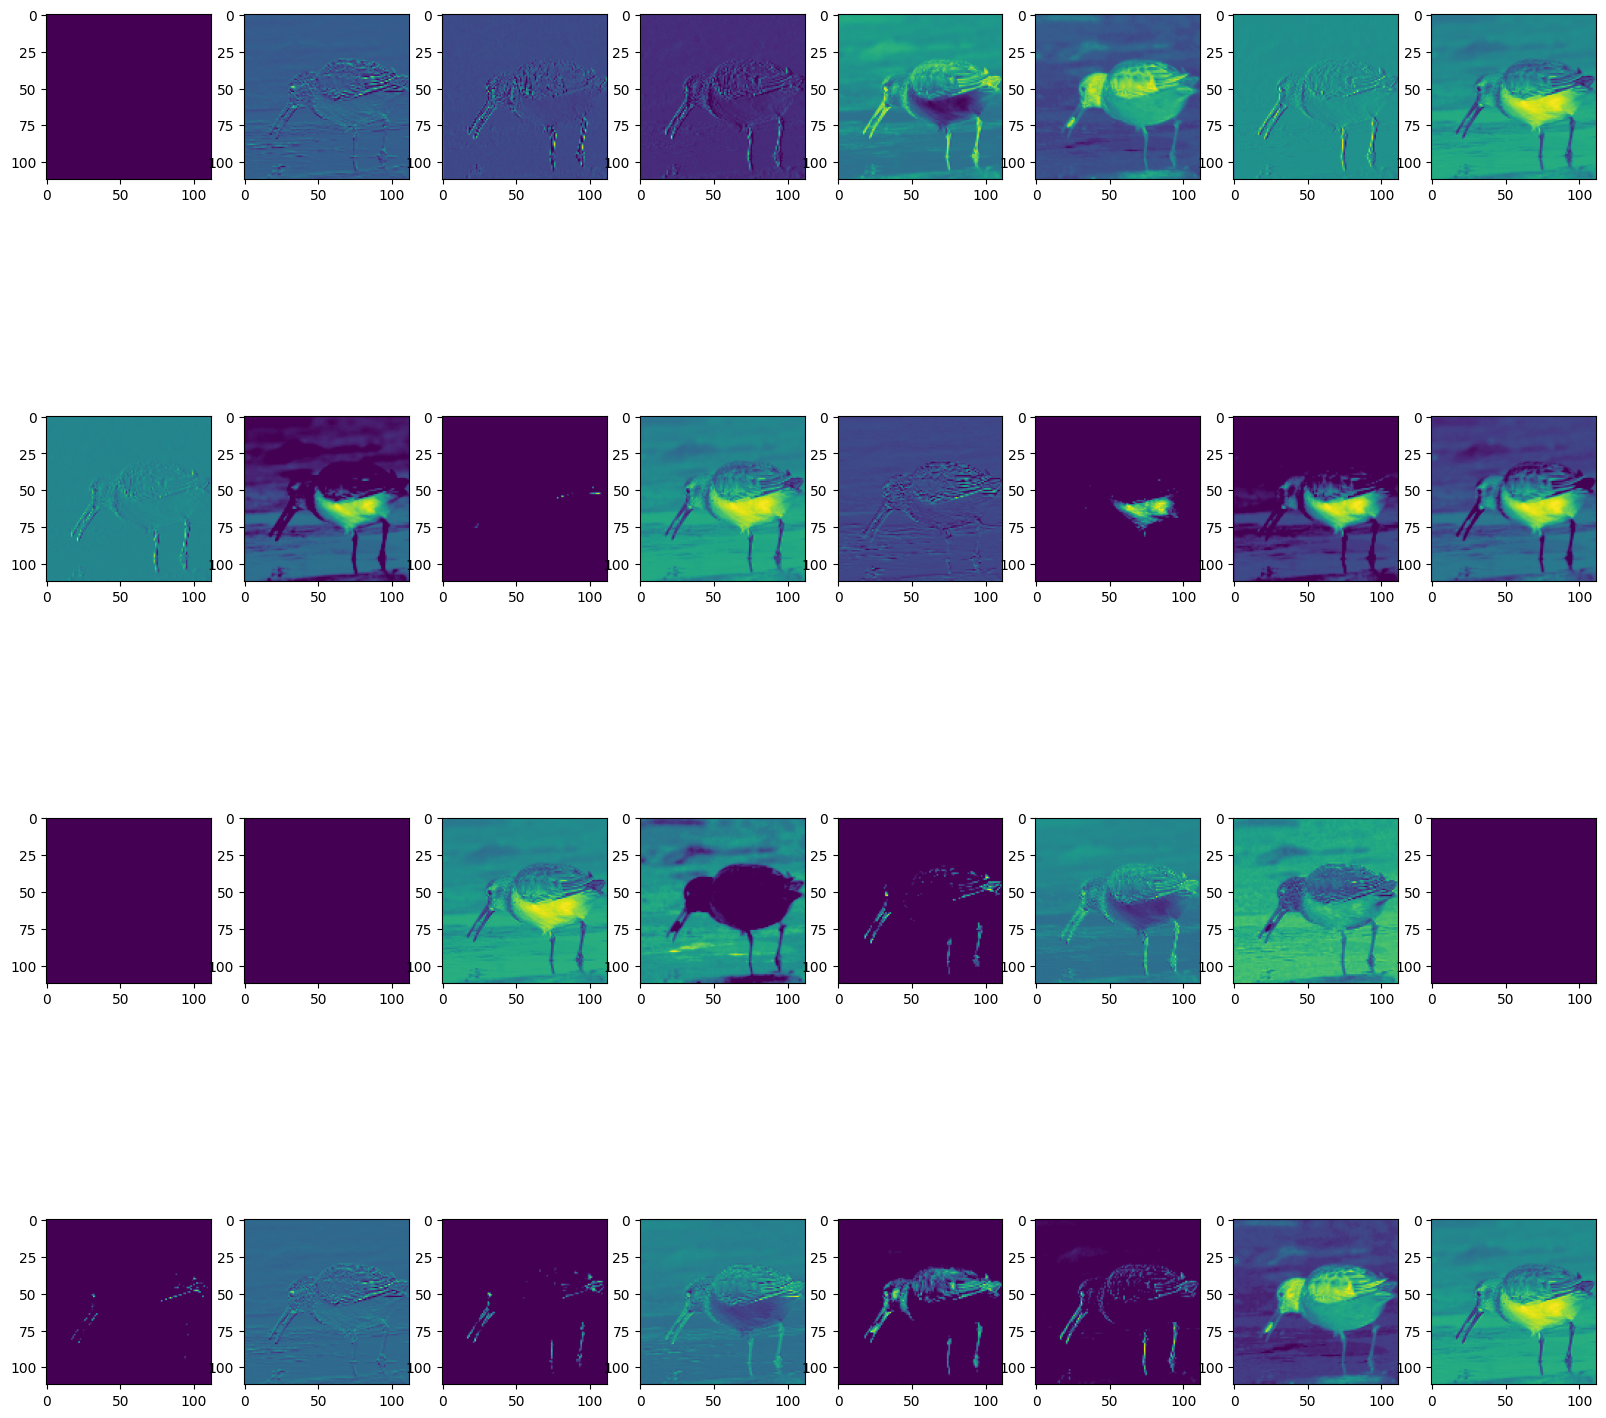

In [4]:
# plot the all feature map
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(4,8, figsize=(20,20))
for i in range(4):
    for j in range(8):
        axs[i,j].imshow(client_output[0,i*8+j,:,:].detach().numpy())

plt.show()

In [ ]:
labels = labels.numpy().astype(int)

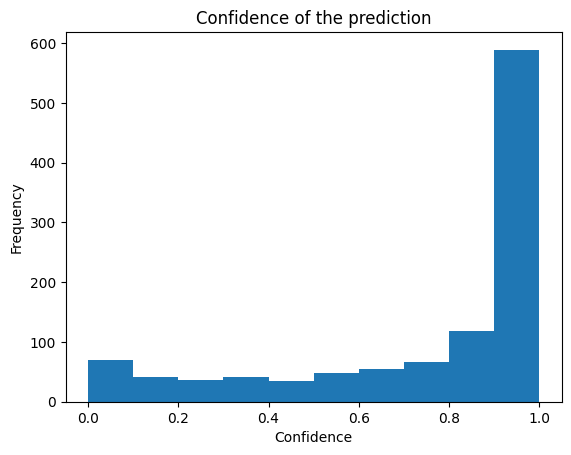

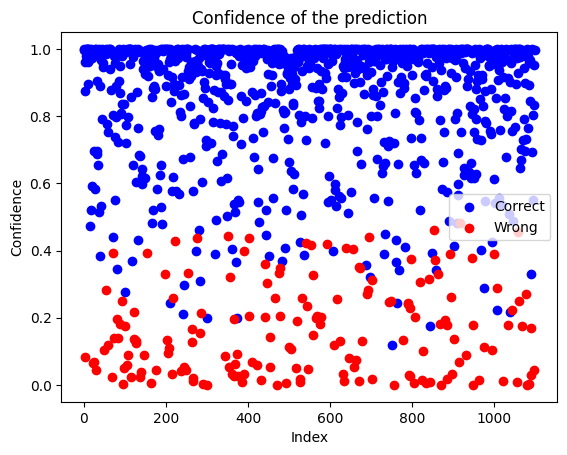

: 

In [41]:
# first, let's get the confidence of the result
output.size() # 100, 1000
label.size() # 100

# get the confidence of the result
import torch.nn.functional as F
confidence = F.softmax(outputs, dim=1)
confidence = confidence.detach().numpy()

confidence = [confidence[i,j] for i,j in enumerate(labels)]
# plot confidence 
from matplotlib import pyplot as plt
plt.figure()
plt.hist(confidence)
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Confidence of the prediction')

# plot scatter plot
plt.figure()
import numpy as np
# true plot blue, wrong plot red
max_output = torch.argmax(outputs, dim=1).numpy()
x_true = np.where(max_output==labels)[0]
x_false = np.where(max_output!=labels)[0]
confidence_true = [confidence[i] for i in x_true]
confidence_false = [confidence[i] for i in x_false]
plt.scatter(x_true, confidence_true, c='blue')
plt.scatter(x_false, confidence_false, c='red')
plt.xlabel('Index')
plt.ylabel('Confidence')
plt.title('Confidence of the prediction')
plt.legend(['Correct', 'Wrong'])
# change legend color
plt.show()


torch.Size([1100, 1000])